<a href="https://colab.research.google.com/github/medayoubaziz/Stroke_prediction/blob/main/stroke_predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier

In [5]:
file1_path = '/content/healthcare-dataset-stroke-data.csv'
stroke_df = pd.read_csv(file1_path)

In [6]:
def explore_cat(inspection_df, x , fillna=True , placeholder='Missing' , figsize=(7,5) , order=None) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 if fillna == True :
  temp_df[x].fillna(placeholder , inplace = True)
 fig,ax = plt.subplots(figsize=figsize)
 sns.countplot(data=temp_df , x=x , ax=ax , order=order)
 ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12 , rotation = 45 , ha = 'right')
 ax.set_title(f'column : {x}' , fontweight = 'bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 nunique = temp_df[x].nunique()
 print(f'There is {nunique} unique values')
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_cat_vs_target(inspection_df , x , y='rating' , placeholder='Missing' , order=None , figsize=(7,5) , fillna = True):
 temp_df = inspection_df.copy()
 if fillna == True:
  temp_df[x].fillna(placeholder, inplace=True)
 else:
  temp_df = temp_df.dropna(subset=[x])
 fig,ax = plt.subplots(figsize=figsize)
 sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6, linewidth=1, edgecolor='black', errorbar=None)
 sns.stripplot(data=temp_df, x=x , y=y , hue=x , ax=ax , order=order, hue_order=order, legend=False , edgecolor='white', linewidth=0.5,
 size=3,zorder=0)
 ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right' , fontsize = 12)
 ax.set_title(f"{x} vs. {y}", fontweight='bold' , fontsize=15)
 fig.tight_layout()
 plt.show()
 return fig, ax

In [7]:
def explore_num(inspection_df , x , figsize=(7.5)) :
 temp_df = inspection_df.copy()
 null_count = temp_df[x].isna().sum()
 null_per = null_count * 100 / len(temp_df)
 nunique = temp_df[x].nunique()
 most_common_value = temp_df[x].value_counts(dropna=False).index[0]
 freq = temp_df[x].value_counts(dropna=False).values[0]
 per_common_value = freq * 100 / len(temp_df)
 gridspec = {'height_ratios':[0.7,0.3]}
 fig,ax = plt.subplots(nrows=2 , figsize=figsize , sharex=True , gridspec_kw=gridspec)
 sns.histplot(data=temp_df , x=x , ax= ax[0])
 sns.boxplot(data=temp_df , x=x , ax=ax[1])
 ax[0].set_title(f"Column: {x}", fontweight='bold' , fontsize = 15)
 sns.despine()
 fig.tight_layout()
 plt.show()
 print(f'There is {null_count} NaN ({round(null_per,2)}%)')
 print(f'There is {nunique} unique values')
 print(f'The most common value is {most_common_value} , occurs {freq} times ({round(per_common_value,2)}%)')
 if per_common_value > 98 :
  print(f'{x}: is a constant or quasi-constant feature and should be dropped')
 else :
  print(f'{x}: is neither constant or a quasi-constant feauture and should be kept')
 return fig,ax

def plot_num_vs_target(inspection_df ,x,y='rating' , figsize=(7,5)):
  temp_df = inspection_df.copy()
  corr = temp_df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.7}
  sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')
  fig.tight_layout()
  plt.show()
  return fig, ax

#Stroke Data

In [ ]:
stroke_df.info()
stroke_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#1. Source of data

https://www.kaggle.com/

#2. Brief description of data

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

#3. What is the target?

Our target is the column : stroke.

#4. What does one row represent? (A person? A business? An event? A product?)

Each row represent a patient with a potential stroke.


#5. Is this a classification or regression problem?

Classification problem.

#6. How many features does the data have?

11 feautres and our target .

#7. How many rows are in the dataset?

5110 rows .

#8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

I'm going to check for duplicated rows and the null values/missing data and explore them and then i'm going to check the balance of our target so it can help me with my model.

In [ ]:
stroke_df.duplicated().sum()

0

In [ ]:
stroke_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<Axes: >

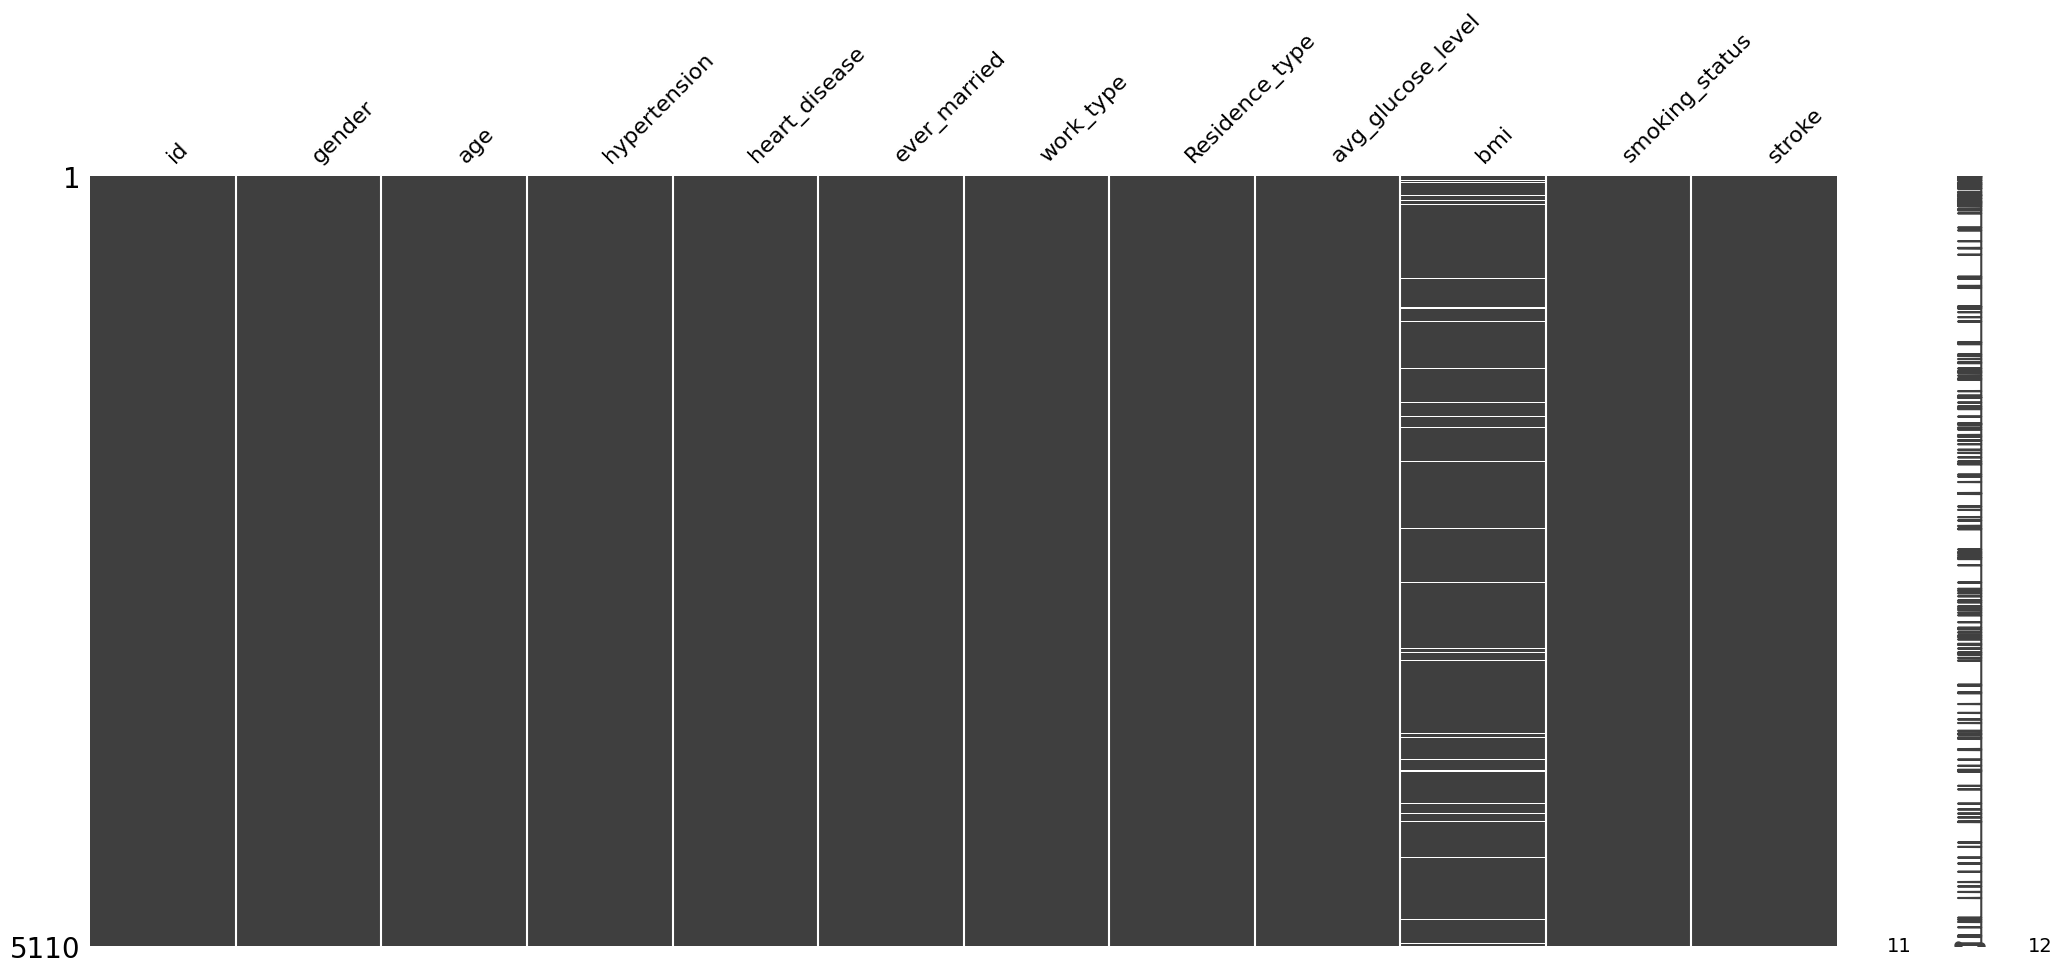

In [ ]:
msno.matrix(stroke_df)

In [ ]:
stroke_df['id'].value_counts().sum()/len(stroke_df)

1.0

In [ ]:
#let's change the index of our data
stroke_df = stroke_df.set_index('id')
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##Target column

In [ ]:
target1 = 'stroke'
stroke_df[target1].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

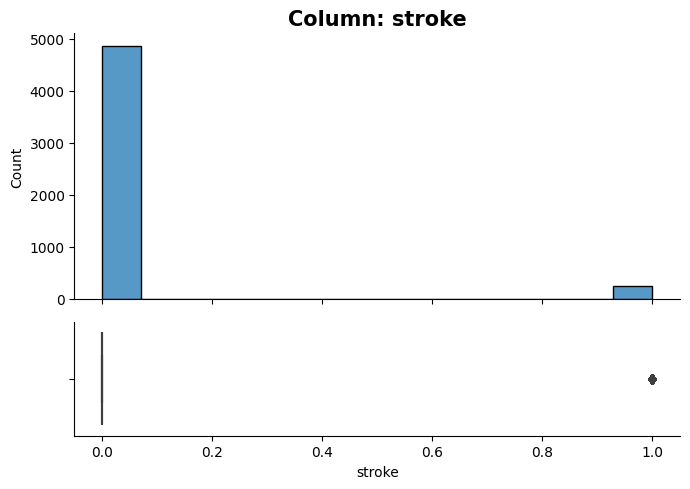

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4861 times (95.13%)
stroke: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,target1,figsize=(7,5));

In [ ]:
stroke_df.select_dtypes('object').columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

##gender column

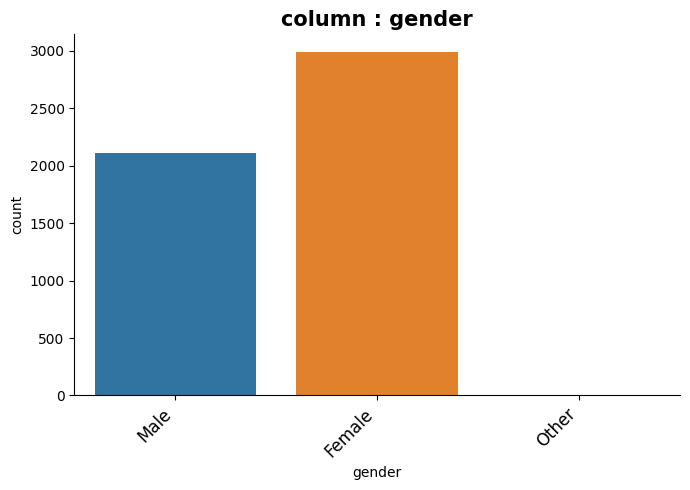

There is 0 NaN (0.0%)
There is 3 unique values
The most common value is Female , occurs 2994 times (58.59%)
gender: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_cat(stroke_df,'gender');

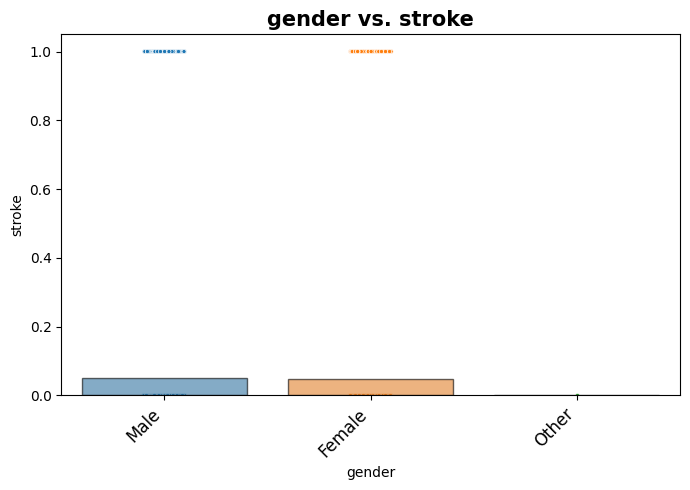

In [ ]:
plot_cat_vs_target(stroke_df,'gender',y=target1);

##ever_married column

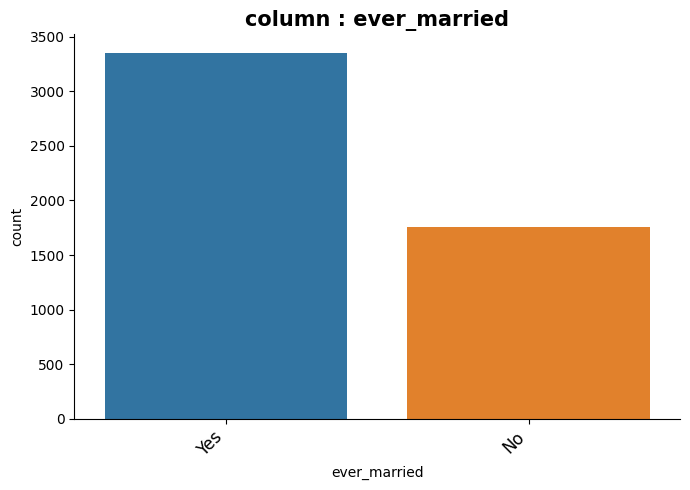

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is Yes , occurs 3353 times (65.62%)
ever_married: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_cat(stroke_df,'ever_married');

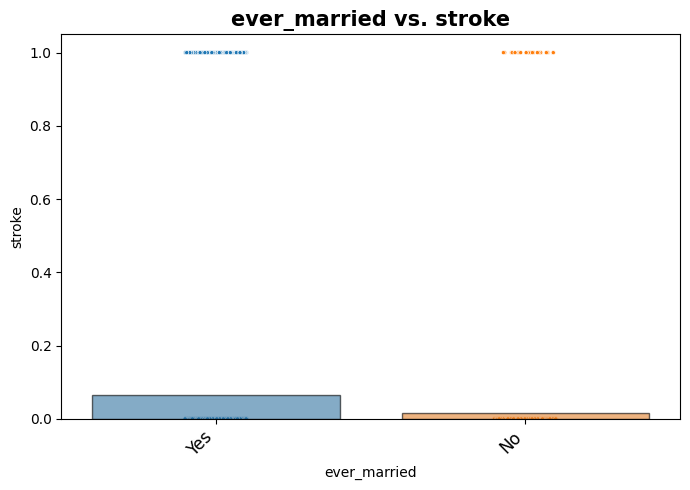

In [ ]:
plot_cat_vs_target(stroke_df,'ever_married',y=target1);

##work_type column

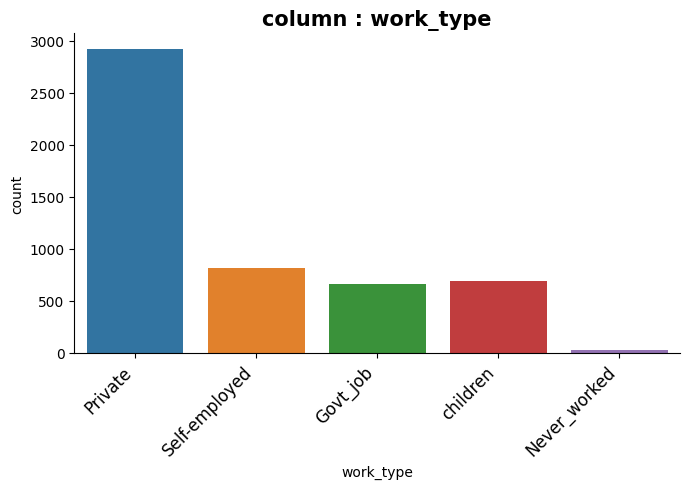

There is 0 NaN (0.0%)
There is 5 unique values
The most common value is Private , occurs 2925 times (57.24%)
work_type: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_cat(stroke_df,'work_type');

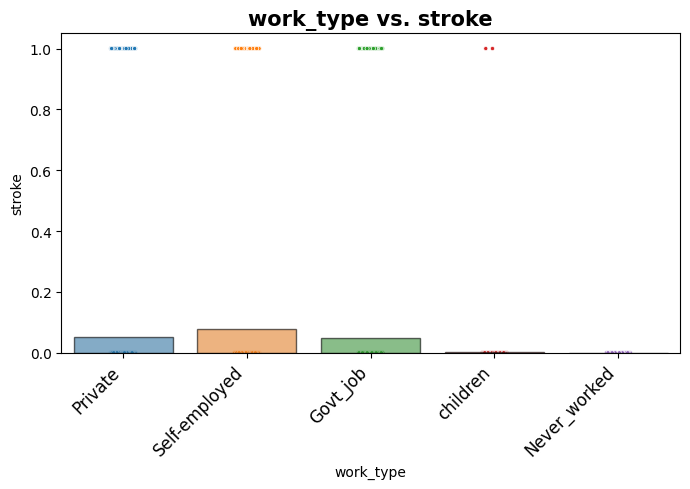

In [ ]:
plot_cat_vs_target(stroke_df,'work_type',y=target1);

##Residence_type column

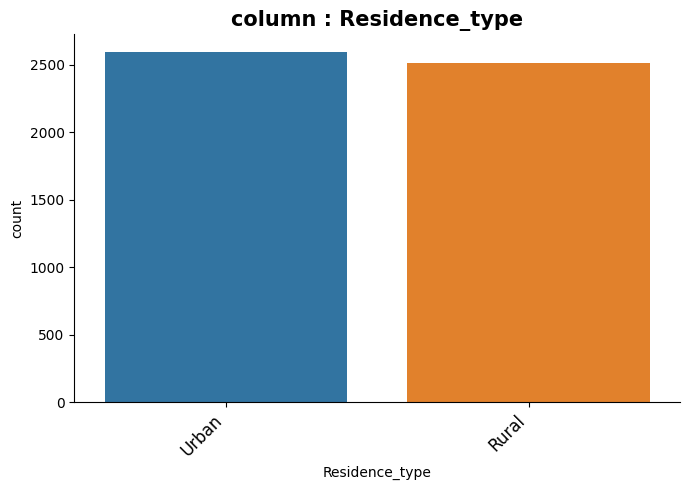

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is Urban , occurs 2596 times (50.8%)
Residence_type: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_cat(stroke_df,'Residence_type');

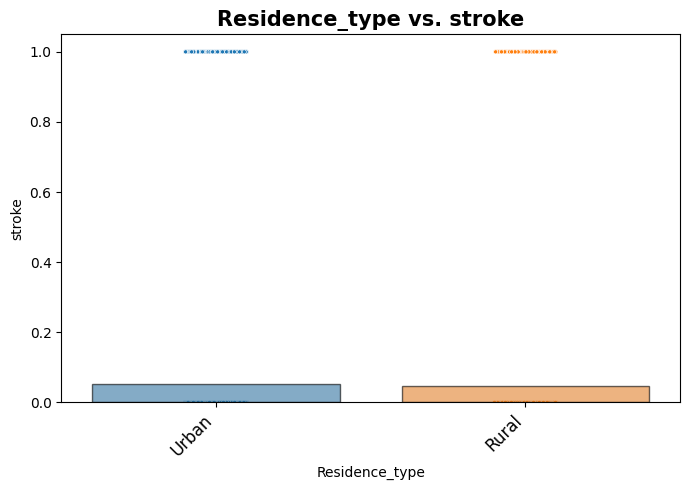

In [ ]:
plot_cat_vs_target(stroke_df,'Residence_type',y=target1);

##smoking_status column

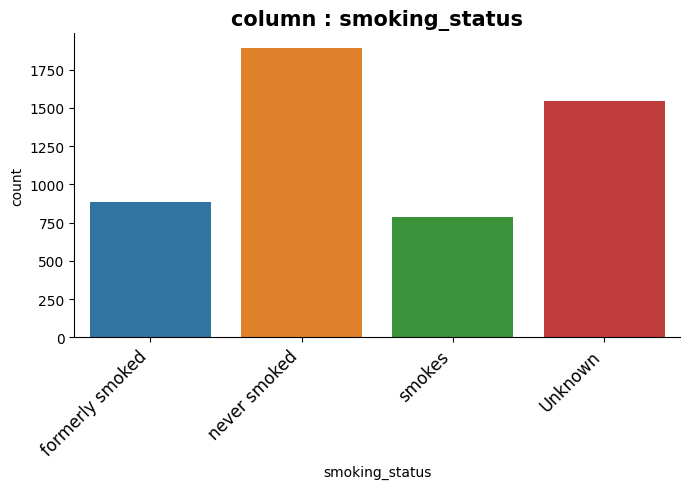

There is 0 NaN (0.0%)
There is 4 unique values
The most common value is never smoked , occurs 1892 times (37.03%)
smoking_status: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_cat(stroke_df,'smoking_status');

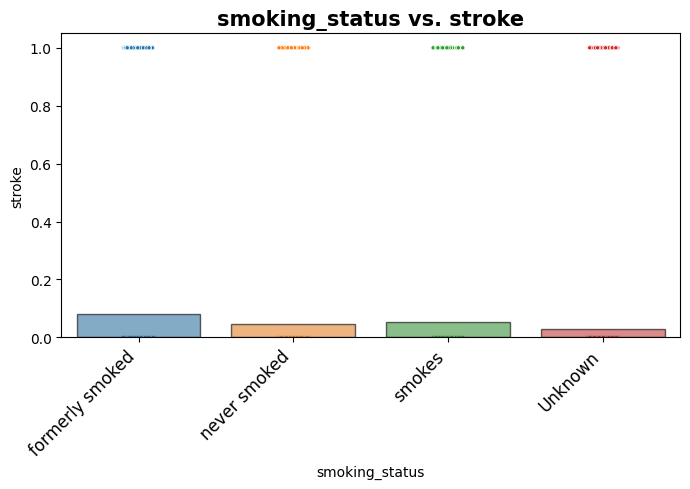

In [ ]:
plot_cat_vs_target(stroke_df,'smoking_status',y=target1);

In [ ]:
stroke_df.select_dtypes('number').columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

##age column

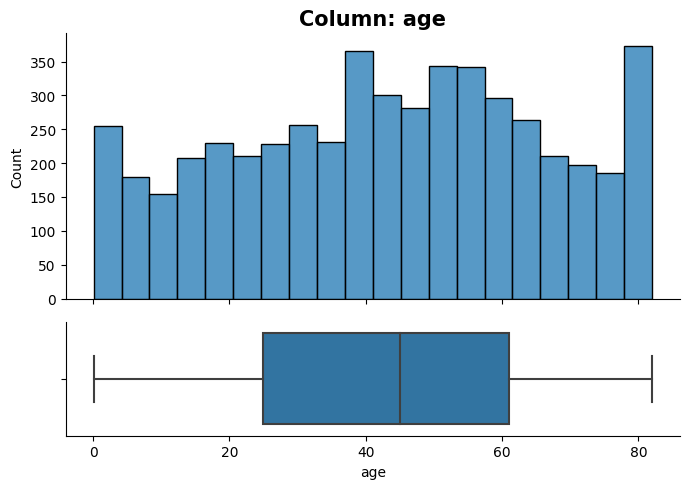

There is 0 NaN (0.0%)
There is 104 unique values
The most common value is 78.0 , occurs 102 times (2.0%)
age: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,'age',figsize=(7,5));

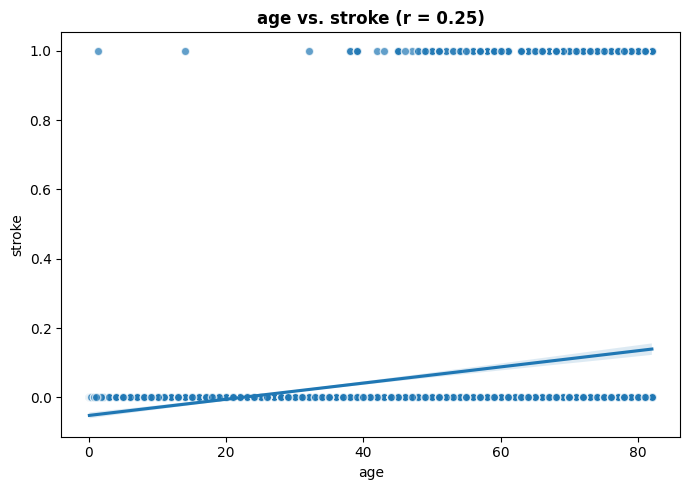

In [ ]:
plot_num_vs_target(stroke_df,'age',y=target1);

##hypertension column

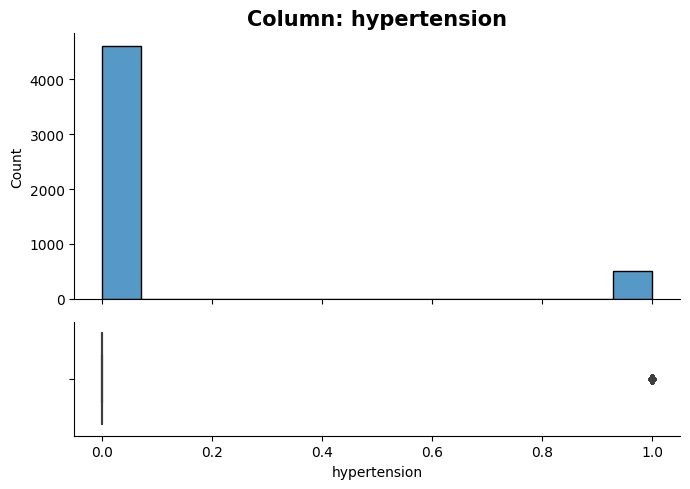

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4612 times (90.25%)
hypertension: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,'hypertension',figsize=(7,5));

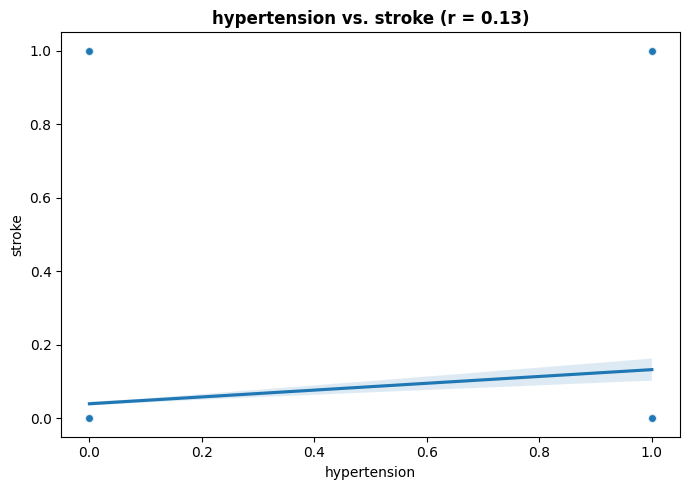

In [ ]:
plot_num_vs_target(stroke_df,'hypertension',y=target1);

##heart_disease column

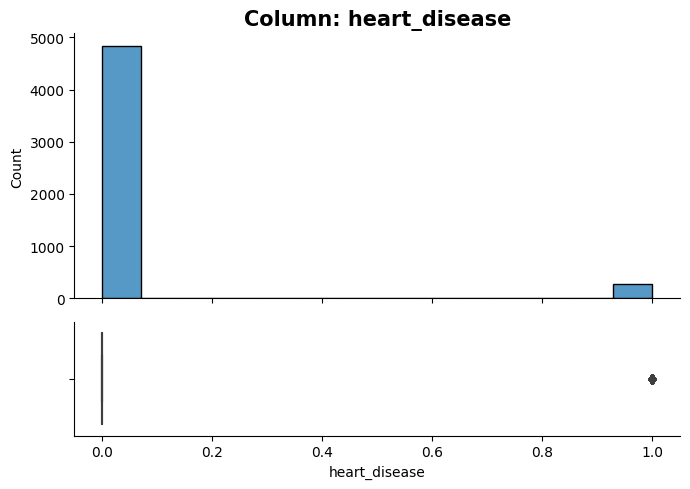

There is 0 NaN (0.0%)
There is 2 unique values
The most common value is 0 , occurs 4834 times (94.6%)
heart_disease: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,'heart_disease',figsize=(7,5));

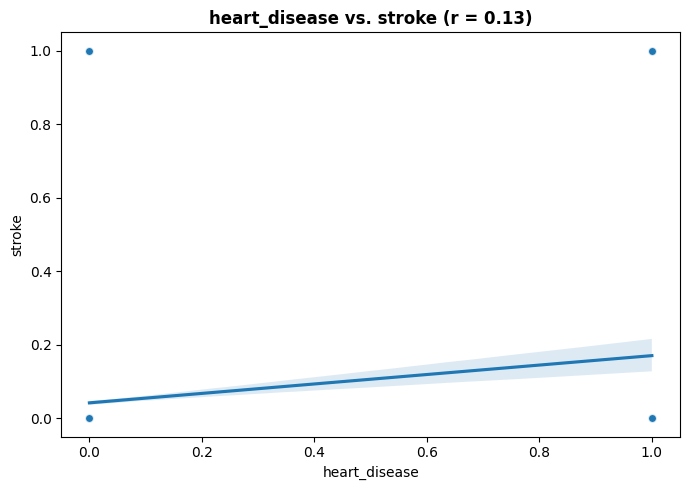

In [ ]:
plot_num_vs_target(stroke_df,'heart_disease',y=target1);

##avg_glucose_level column

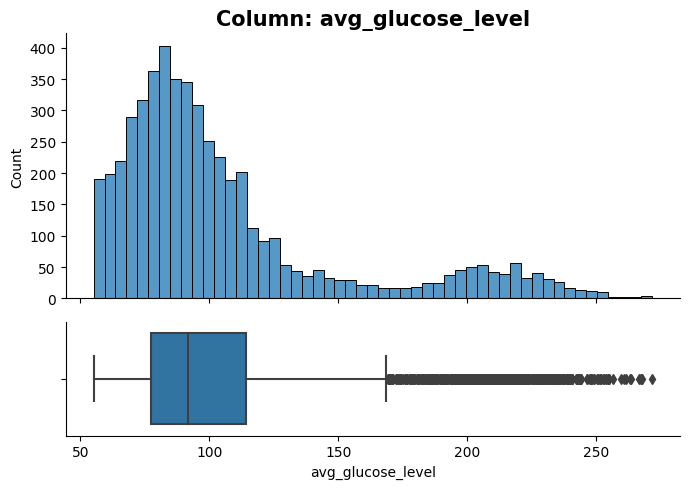

There is 0 NaN (0.0%)
There is 3979 unique values
The most common value is 93.88 , occurs 6 times (0.12%)
avg_glucose_level: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,'avg_glucose_level',figsize=(7,5));

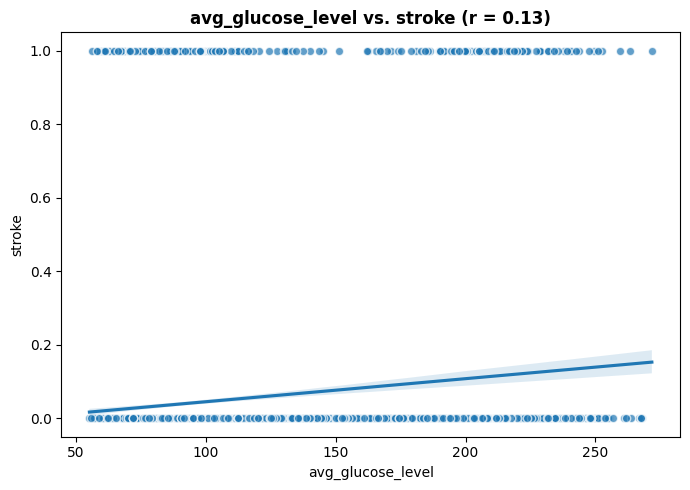

In [ ]:
plot_num_vs_target(stroke_df,'avg_glucose_level',y=target1);

##bmi column

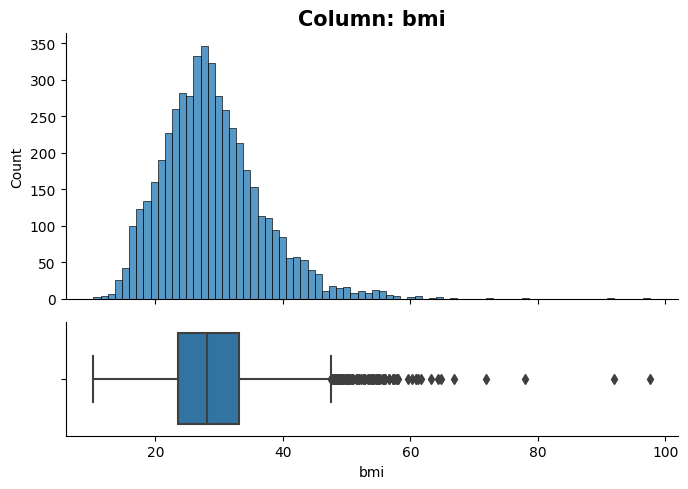

There is 201 NaN (3.93%)
There is 418 unique values
The most common value is nan , occurs 201 times (3.93%)
bmi: is neither constant or a quasi-constant feauture and should be kept


In [ ]:
explore_num(stroke_df,'bmi',figsize=(7,5));

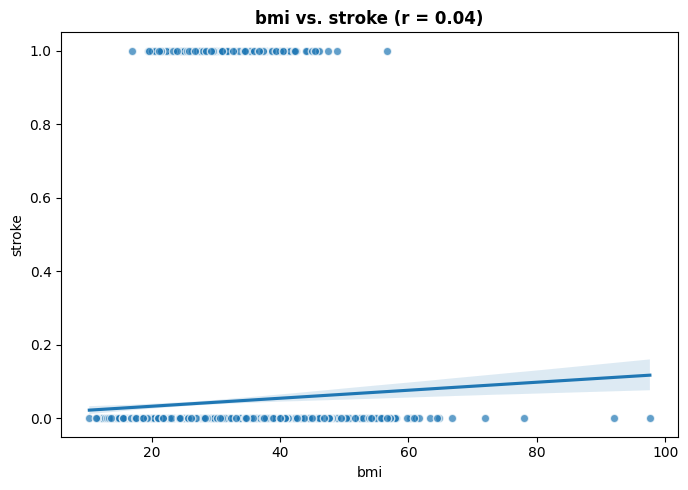

In [ ]:
plot_num_vs_target(stroke_df,'bmi',y=target1);

bmi is a numerical feature and it has missing values , so for the imputation i will use the median strategy.

<ipython-input-88-cc10ffe11211>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = stroke_df.corr()


<Axes: >

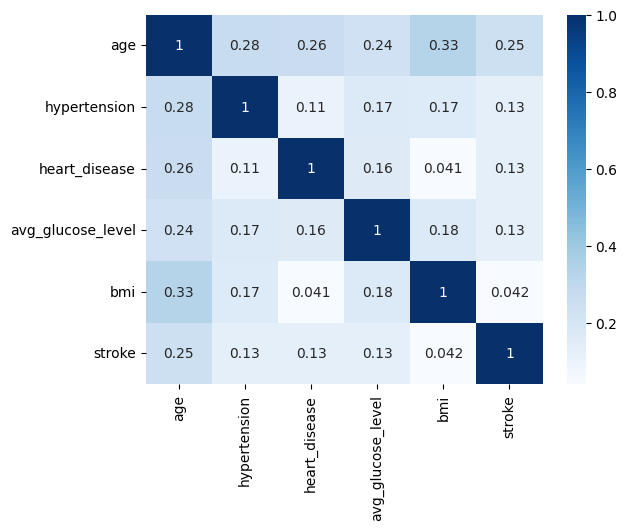

In [ ]:
cor = stroke_df.corr()
sns.heatmap(cor, cmap = 'Blues' , annot=True)

In [ ]:
stroke_df.describe().round(2)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,43.23,0.1,0.05,106.15,28.89,0.05
std,22.61,0.3,0.23,45.28,7.85,0.22
min,0.08,0.0,0.00,55.12,10.30,0.00
25%,25.00,0.0,0.00,77.24,23.50,0.00
50%,45.00,0.0,0.00,91.88,28.10,0.00
75%,61.00,0.0,0.00,114.09,33.10,0.00
max,82.00,1.0,1.00,271.74,97.60,1.00
